# Ligand Selection and Preparation, Docking and Analysis

This notebook contains the code necessary to; prepare the ligands for docking, run docking in smina, and analyse the results of the docking.

In [2]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import random
import string
import csv

from molbloom import buy

from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, Descriptors, Draw, SDMolSupplier, SDWriter
from rdkit.Chem.rdmolfiles import MolToPDBFile
from rdkit.ML.Descriptors import MoleculeDescriptors

from standardiser import standardise

# set paths for data, results, and source code
DATAPATH = "../data"
RESULTSPATH = "../results"
SOURCEPATH = "../src"

# activate the docking-env environment (assumed to have been done already)
# (no code is included here as the exact method of activating the environment can vary)

## Development of scorer.py 

This is the function that can be called from the CLI in order to run the docking. It is saved in /src.

## Ligand Standardisation

Ligand selection is done prior to this step. This can be done 1) manually, searching databased such as ChemBL, 2) via Ersilia's similarity search models, or 3) automatically via a generative model. .csv files are required, containing only an ID column (column A) and a smiles column (column B). Input files must be vetted to only contain these. If using methods 1 or 2 to provide a .csv file, the datasets can be curated manually, with empty rows, duplicate and unnecessary columns removed. ID's must only contain an integer. 

Standardisation involves converting smiles to molfiles, standardising with standardiser, converting back to smiles and remomving any smiles that are unable to be standardised.

## Ligand Filtering

Filtering is an important step to ensure only ligands that fit within specified paramters are prepared, docked an analysed. Compounds that are too small or large will not only slow the docking process, but will fall outside of the'drug-like compounds' parameters. 

Filtering involves generating descriptors of the std_smiles using RDkit. RDkit has 200 molecular descriptors. I am filtering only by molecular weight (300-800 da), but as all descriptors are generated, this step and be optimised for specific needs (e.g. constraining the number of rotatable bonds, or adhering specifically to Lipinski's rule of 5).

### Standardiser and filterer together with no intermediate .csv files

In [3]:
reference_lib = os.path.join(DATAPATH, "smiles", "200k_for_chemsampler.csv")
round_2 = os.path.join(DATAPATH, "smiles", "run_again.csv")

# Load the CSV file
df = pd.read_csv(reference_lib)

# Drop the first 87292 rows
df = df.iloc[87292:]

# Save the new CSV file
df.to_csv(round_2, index=False)

In [5]:
smiles_csv = os.path.join(DATAPATH, "smiles", "test100mols.csv")
filtered_std_smiles = os.path.join(DATAPATH, "smiles", "filtered_std_test100mols.csv")

def prep_smiles(smiles_csv):
    df = pd.read_csv(smiles_csv)

    mols = [Chem.MolFromSmiles(smi) for smi in df["SMILES"].tolist()]

    std_mols = []

    for mol in mols:
        if mol is not None:
            try:
                std_mol = standardise.run(mol)
            except:
                std_mol = np.nan
        else:
            std_mol = np.nan
        std_mols += [std_mol]

    std_smiles = []

    for std_mol in std_mols:
        if std_mol is not None:
            try:
                std_smi = Chem.MolToSmiles(std_mol)
            except:
                std_smi = np.nan
        else:
            std_smi = np.nan
        std_smiles += [std_smi]

    df["ST_SMILES"] = std_smiles

    df = df[df["ST_SMILES"].notna()]

    df.drop(columns=["SMILES"], inplace=True)

    mols = [Chem.MolFromSmiles(smi) for smi in df["ST_SMILES"].tolist()]

    mol_wts = []

    for mol in mols:
        mol_wt = Descriptors.MolWt(mol)
        mol_wts += [mol_wt]

    df["mol_wt"] = mol_wts

    df_filtered = df[df["mol_wt"].between(250, 450)]
    df_filtered.drop(columns=["mol_wt"], inplace=True)
    df_filtered.to_csv(filtered_std_smiles, index=False)

prep_smiles(smiles_csv) 


/tmp/ipykernel_2803/3960641654.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=["mol_wt"], inplace=True)


## Ligand Preparation

The standardised, filetered ligands are now ready for preparation. smina, a branch of AutoDock Vina, is being used as the docking software and can accept both .pdbqt or .sdf inout file format. As multiple entries can be consolidated into a single .sdf file, this is the file format we are using here. 

The process involves generating a 2D molfile from the list of std_smiles, and converting these to 3D via embedding. The choice of embdding paramters can be optimised. Certain molecules will not emded due to intrinsic molecular complexities not being compatible with RDkit's algorithm. These can be removed - we will have a long list of smiles, so removal of a small percentage of complex molecules is not a problem. These 3D molfiles are then converted to .pdb format and then to .sdf format with RDkit and openbabel, repsectively. The .sdf files are then merged together. Again, some molecules will not be written into the final merged.sdf file due to valency errors. This is not a problem. again, as we will have a long list of molecules for docking.

In [4]:
pH = 7.4
sdf_folder = os.path.join(DATAPATH, "smiles")

In [ ]:
def prepare_ligands_sdf(filtered_std_smiles, pH, header_len=1, output_dir = sdf_folder, delim=',') -> list:

    out_sdfs = [] 
    
    print(filtered_std_smiles)
    
    with open(filtered_std_smiles, 'r') as csv_file: 
            
        for entry in csv_file.readlines()[header_len:]:
            
            ID, ST_SMILES = entry.split(delim)[:2]            
           
            # Convert smiles str to 3D coordinates
            mol = Chem.MolFromSmiles(ST_SMILES)
            mol = Chem.AddHs(mol)
            ps = AllChem.ETKDGv3()
            ps.useRandomCoords = True
            result = AllChem.EmbedMolecule(mol, ps)
                        
            if type(result) is int:
                if result == -1:
                    continue
           
            # Ouput coords to pdb
            pdb_name = f"{output_dir}/{ID}.pdb"
            MolToPDBFile(mol, pdb_name)
       
            # Protonate according to pH, convert to .sdf
            sdf_name = f"{output_dir}/{ID}.sdf"
            ! obabel {pdb_name} -pH {pH} -O {sdf_name} 
          
            os.remove(pdb_name) # removes the .pdb files after obabel protonates and converts to .sdf
                       
            out_sdfs.append(sdf_name)
            
    return out_sdfs

def merge_sdfs(out_sdfs, merged_sdf):

    mols = []
    for s in out_sdfs:
        suppl = Chem.SDMolSupplier(s)
        for  mol in suppl:
            if mol is None:
                continue
        else:
            mols += [mol]
        os.remove(s)

    with Chem.SDWriter(merged_sdf) as w:
        for mol in mols:
            if mol is None:
                continue
            else:
                w.write(mol)           
    

def prepare_and_merge_ligands(filtered_std_smiles,  pH, header_len=1, output_dir='', delim=','):
    ligands = prepare_ligands_sdf(filtered_std_smiles,  pH, header_len, output_dir, delim)
    merge_sdfs(ligands, output_dir+"/merged.sdf") 


prepare_and_merge_ligands(filtered_std_smiles, pH, output_dir=sdf_folder)

In [ ]:
#This is simply a check of how many molecules are lost during embedding, conversion and writing to sdf.

suppl = Chem.SDMolSupplier('../data/validation_lists/merged.sdf')
sdfs = [x for x in suppl]
smiles = pd.read_csv('../data/validation_lists/allsimilar.csv')
filt = pd.read_csv('../data/validation_lists/filtered_std_smiles.csv')

print(f"num of std_smiles: {len(smiles)}\tnum of merged sdfs: {len(sdfs)}")

## Docking with smina

smina.static must be downloaded, at least for linux - if running on windows or similar this may be different. The receptor  must be manually prepped using AutoDock Tools. It is also a good idea to use ADT to define the grid box and make a note of the dimensions - just be sure to alter the size options to 1 angstrom. It is a good idea to include a seed - this ensures reproducibility in the results. Here, I am only using NumModes = 1, as I only want to output the top docking score for each molecule. If doing single molecules or only a small number it is a good idea to keep this at 9, as the top score may not always be the best. Do not add hydrogens here as we have already defiend the ligands with openbabel. Scoring funciton being used is vinardo - this outperforms vina in the literature and preliminary data shows that, with my datasets, it is less biased.

In [52]:
# The below is smina, run using the single .sdf file with all ligands, nconf=1. 

receptor = os.path.join(DATAPATH, "protein", "pabb_model1.pdbqt") 
ligands = os.path.join(DATAPATH, "smiles", "smallmols_vina_merged.sdf")  
log = os.path.join(RESULTSPATH, "outputs", "smallmols_vina_log.txt") 
docking_output = os.path.join(RESULTSPATH, "outputs", "smallmols_vina_outputs.sdf") 
smina = os.path.join(SOURCEPATH, "smina.static") 

docking_cmd = smina  + " -r " + receptor + " -l " + ligands + " -o " + docking_output + " --log " + log + " --seed 42 " + " --center_x 74 " + " --center_y 44 " + " --center_z 63 " + " --size_x 22 " + " --size_y 22 " + " --size_z 20 " + " --exhaustiveness 8 " + " --num_modes 1 " + " --addH off " + " --scoring vinardo "

# os.system(docking_cmd)

## Docking Analysis

Here, the output.sdf will be used to form a list of minimizedAffinity, compound ID's and std_smiles. This can be used for a number of things - for use in a generative model, or descriptors can be re-added to the final list for validation. The former is the general purpose of this project, and the latter has been done in order to form the validation.ipynb.

In [ ]:
#linking smiles and affiinity scores

affinities_id_smiles = os.path.join(RESULTSPATH, "outputs", "smallmols_vina_affinity_id_smiles.csv")


def affinities_to_smiles(docking_output):

    df = PandasTools.LoadSDF(docking_output, embedProps=True, molColName=None, smilesName='SMILES')
    df['ID'] = df['ID'].map(lambda x: x.lstrip('..data/smiles/').rstrip('.pdb'))

    df.to_csv(affinities_id_smiles, index=False)

affinities_to_smiles(affinities_id_smiles)

# Initial dataset preparation from ChemBL database

### Initial dataset preparation

The reference_library.csv from https://github.com/ersilia-os/groverfeat/blob/main/data/reference_library.csv was downloaded and addded to the repo. This was filtered based loosely on Lipinski's rule of 5, but with caveats for lead compounds. More info can be found on the wiki page here https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five.

The aim of producing this dataset of ~200k lead-like compounds is to dock a large number of potential leads into PabB and obtain docking scores. Compounds that dock with a high affinity when compared to the known binders can be used alongside the known binders as a list of compounds to seed chemsampler. We are looking for ~100 compounds to use as a seed. Chemsampler will then sample and generate ~1 million compounds. These can be filtered, remaining compounds re-docked and further generation can occur.

Generative steps are house in another notebook.

The output of the below will docked using scorer.py, the function developed above.

In [ ]:
# Define the paths for the input and output files
smiles_csv = os.path.join(DATAPATH, 'smiles', 'reference_library.csv')
filtered_smiles = os.path.join(DATAPATH, 'smiles', 'testfiltered_std_smiles.csv')

# Read the SMILES strings from the CSV file into a DataFrame
df = pd.read_csv(smiles_csv, skiprows=1, header=None, names=['SMILES']) #can add skiprows=1 is there is a smiles header

# Create an empty list to store the selected SMILES strings
selected = []

# Loop through the SMILES strings and filter by molecular properties
for s in df['SMILES']:
    mol = Chem.MolFromSmiles(s)
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hacceptors = Descriptors.NumHAcceptors(mol)
    hdonors = Descriptors.NumHDonors(mol)
    numrotatablebonds = Descriptors.NumRotatableBonds(mol)
    if 250 <= mw <= 450 and 1 <= logp <= 3 and hacceptors <= 5 and hdonors <= 4 and numrotatablebonds <= 5: 
        selected.append(s)

# Write the selected SMILES strings to a new CSV file
df_selected = pd.DataFrame({'SMILES': selected})
df_selected.to_csv(filtered_smiles, index=False)

In [ ]:
len(df["SMILES"]) #how many original smiles?

The above is 1999381.

In [ ]:
len(selected) #how many in our list?

The above is 201515.

In [ ]:
id_list = (range(0, 201515))
len(id_list) # must create a list of 'IDs' for the ID column - this is required for the scorer.py

In [ ]:
filtered_selected = os.path.join(DATAPATH, "smiles", "200k_for_chemsampler.csv")

dict = {'ID': id_list, 'SMILES': selected}  
df = pd.DataFrame(dict) 
df.to_csv(filtered_selected, index=False) 

#saves a .csv file with a column for ID and a column for SMILES which will be used to run the first round of docking into PabB.

## Preparation of Docking Output for Chemsampler

Below, I am splitting the output of the docking by MW - I want to create 2 datasets, one for molecules between 250-350, and one for 350-450.

First, I want to filter by affinity, removing all below -8.5. I want to do this for both docking runs.

In [2]:
# Specify the paths to the input and output files
docking_output = os.path.join(DATAPATH, "200k_reference_output", "docking-poses.sdf")
output_file = os.path.join(DATAPATH, "200k_reference_output", "filtered_poses.sdf")
writer = Chem.SDWriter(output_file)
threshold = -8.5


# Load the docking output to a dataframe
df = PandasTools.LoadSDF(docking_output, embedProps=True, molColName=None, smilesName='SMILES')

# Convert the Affinity column to float
df["minimizedAffinity"] = df["minimizedAffinity"].astype(float)

# Filter the dataframe by affinity scores
filtered_df = df.query("minimizedAffinity <= @threshold")

# Create a set of IDs from the filtered dataframe
filtered_ids = set(filtered_df["ID"])

# Read the original SDF file and write molecules to the output file if the ID is in the filtered set
suppl = Chem.SDMolSupplier(docking_output)
for mol in suppl:
    if mol is not None and mol.GetProp("_Name") in filtered_ids:
        writer.write(mol)

# Close the writer object
writer.close()


[11:43:32] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[11:43:38] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[11:43:48] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[11:43:48] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[11:43:49] ERROR: EOF hit while reading bonds
[11:43:49] ERROR: moving to the beginning of the next molecule
[11:43:50] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[11:43:51] Conflicting single bond directions around double bond at index 4.
[11:43:51]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:43:52] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[11:43:57] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[11:43:57] WARNING

Now, I want to do the same for the second round of the docking.

In [3]:
# Specify the paths to the input and output files
docking_output = os.path.join(DATAPATH, "reference_output_2", "docking-poses.sdf")
output_file = os.path.join(DATAPATH, "reference_output_2", "filtered_poses.sdf")
writer = Chem.SDWriter(output_file)
threshold = -8.5


# Load the docking output to a dataframe
df = PandasTools.LoadSDF(docking_output, embedProps=True, molColName=None, smilesName='SMILES')

# Convert the Affinity column to float
df["minimizedAffinity"] = df["minimizedAffinity"].astype(float)

# Filter the dataframe by affinity scores
filtered_df = df.query("minimizedAffinity <= @threshold")

# Create a set of IDs from the filtered dataframe
filtered_ids = set(filtered_df["ID"])

# Read the original SDF file and write molecules to the output file if the ID is in the filtered set
suppl = Chem.SDMolSupplier(docking_output)
for mol in suppl:
    if mol is not None and mol.GetProp("_Name") in filtered_ids:
        writer.write(mol)

# Close the writer object
writer.close()


[11:45:02] Conflicting single bond directions around double bond at index 4.
[11:45:02]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:45:05] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[11:45:21] Conflicting single bond directions around double bond at index 4.
[11:45:21]   BondStereo set to STEREONONE and single bond directions set to NONE.
[11:45:22] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


Now, I want to combine the 2 filtered SDF files, and save in reference_output_2 folder.

In [4]:
filtered_poses_1 = os.path.join(DATAPATH, "200k_reference_output", "filtered_poses.sdf")
filtered_poses_2 = os.path.join(DATAPATH, "reference_output_2", "filtered_poses.sdf")
merged_filtered_poses = os.path.join(DATAPATH, "reference_output_2", "merged_filtered_poses.sdf")

# Read the first SDF file
suppl1 = Chem.SDMolSupplier(filtered_poses_1)

# Read the second SDF file
suppl2 = Chem.SDMolSupplier(filtered_poses_2)

# Merge the molecules from both files
merged_mols = []
for mol in suppl1:
    if mol is not None:
        merged_mols.append(mol)
for mol in suppl2:
    if mol is not None:
        merged_mols.append(mol)

# Write the merged molecules to a new SDF file
writer = Chem.SDWriter(merged_filtered_poses)
for mol in merged_mols:
    writer.write(mol)
writer.close()

How many poses are returned after filtering?

In [5]:
# Read the merged SDF file
suppl = Chem.SDMolSupplier(merged_filtered_poses)

# Count the number of molecules
num_mols = 0
for mol in suppl:
    if mol is not None:
        num_mols += 1

# Print the result
print("Number of molecules: ", num_mols)

Number of molecules:  2257


Then, I want to split this into 4 datasets, one for 250-300, 300-350, 350-400 and 400-450 Da.

In [6]:
# Specify the input and output file names
input_file = os.path.join(DATAPATH, "reference_output_2", "merged_filtered_poses.sdf")
output_file_smallest = os.path.join(DATAPATH, "reference_output_2", "filtered_poses_250-300.sdf")
output_file_small = os.path.join(DATAPATH, "reference_output_2", "filtered_poses_300-350.sdf")
output_file_large = os.path.join(DATAPATH, "reference_output_2", "filtered_poses_350-400.sdf")
output_file_largest = os.path.join(DATAPATH, "reference_output_2", "filtered_poses_400-450.sdf")

# Read the filtered SDF file to a dataframe
suppl = Chem.SDMolSupplier(input_file)
df_filtered = pd.DataFrame(columns=["ID", "MolWt"])
for mol in suppl:
    if mol is not None:
        df_filtered = df_filtered.append({
            "ID": mol.GetProp("_Name"),
            "MolWt": Descriptors.MolWt(mol)
        }, ignore_index=True)

# Convert the ID column to string
df_filtered["ID"] = df_filtered["ID"].astype(str)

# Split the dataframe into two based on the molecular weight
df_1 = df_filtered.query("250 <= MolWt < 300")
df_2 = df_filtered.query("300 <= MolWt < 350")
df_3 = df_filtered.query("350 <= MolWt < 400")
df_4 = df_filtered.query("400 <= MolWt <= 450")

# Create sets of IDs for the two dataframes
id_set_1 = set(df_1["ID"])
id_set_2 = set(df_2["ID"])
id_set_3 = set(df_3["ID"])
id_set_4 = set(df_4["ID"])

# Create writer objects for the output files
writer_1 = Chem.SDWriter(output_file_smallest)
writer_2 = Chem.SDWriter(output_file_small)
writer_3 = Chem.SDWriter(output_file_large)
writer_4 = Chem.SDWriter(output_file_largest)

# Read the filtered SDF file and write molecules to the output files based on the ID sets
suppl = Chem.SDMolSupplier(input_file)
for mol in suppl:
    if mol is not None:
        mol_id = mol.GetProp("_Name")
        if mol_id in id_set_1:
            writer_1.write(mol)
        elif mol_id in id_set_2:
            writer_2.write(mol)
        mol_id = mol.GetProp("_Name")
        if mol_id in id_set_3:
            writer_3.write(mol)
        elif mol_id in id_set_4:
            writer_4.write(mol)
            

# Close the writer objects
writer_1.close()
writer_2.close()
writer_3.close()
writer_4.close()

/tmp/ipykernel_723/2478726491.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append({
/tmp/ipykernel_723/2478726491.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append({
/tmp/ipykernel_723/2478726491.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append({
/tmp/ipykernel_723/2478726491.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append({
/tmp/ipykernel_723/2478726491.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

How many are in each one?

In [7]:
# Define a function to count the number of molecules in an SDF file
def count_molecules(sdf_file):
    suppl = Chem.SDMolSupplier(sdf_file)
    num_mols = 0
    for mol in suppl:
        if mol is not None:
            num_mols += 1
    return num_mols

# Count the number of molecules in each output file
num_mols_1 = count_molecules(output_file_smallest)
num_mols_2 = count_molecules(output_file_small)
num_mols_3 = count_molecules(output_file_large)
num_mols_4 = count_molecules(output_file_largest)

# Print the results
print("Number of molecules in filtered_poses_250-300.sdf: ", num_mols_1)
print("Number of molecules in filtered_poses_300-350.sdf: ", num_mols_2)
print("Number of molecules in filtered_poses_350-400.sdf: ", num_mols_3)
print("Number of molecules in filtered_poses_400-450.sdf: ", num_mols_4)


Number of molecules in filtered_poses_250-300.sdf:  196
Number of molecules in filtered_poses_300-350.sdf:  667
Number of molecules in filtered_poses_350-400.sdf:  870
Number of molecules in filtered_poses_400-450.sdf:  522


Now, I will sort by minimizedAffinity. This code will sort each of the four SDF files by minimized affinity and write the sorted molecules to new SDF files with the prefix "sorted_" added to the original filenames.

In [8]:
# Specify the paths to the input and output files
input_files = [os.path.join(DATAPATH, "reference_output_2", "filtered_poses_250-300.sdf"),
               os.path.join(DATAPATH, "reference_output_2", "filtered_poses_300-350.sdf"),
               os.path.join(DATAPATH, "reference_output_2", "filtered_poses_350-400.sdf"),
               os.path.join(DATAPATH, "reference_output_2", "filtered_poses_400-450.sdf")]
output_files = [os.path.join(DATAPATH, "reference_output_2", "sorted_filtered_poses_250-300.sdf"),
                os.path.join(DATAPATH, "reference_output_2", "sorted_filtered_poses_300-350.sdf"),
                os.path.join(DATAPATH, "reference_output_2", "sorted_filtered_poses_350-400.sdf"),
                os.path.join(DATAPATH, "reference_output_2", "sorted_filtered_poses_400-450.sdf")]

# Loop over the input and output files
for i in range(len(input_files)):
    # Load the SDF file using an SDMolSupplier object
    suppl = SDMolSupplier(input_files[i])
    
    # Create a list of tuples containing the molecules and their affinity scores
    mol_score_list = [(mol, mol.GetDoubleProp('minimizedAffinity')) for mol in suppl]
    
    # Sort the list of molecules by their affinity scores in descending order
    mol_score_list.sort(key=lambda x: x[1])
    
    # Write the sorted molecules to a new SDF file using an SDWriter object
    writer = SDWriter(output_files[i])
    for mol, score in mol_score_list:
        writer.write(mol)
    writer.close()


The sorted posed were visually inspected before being selected for seeding chemsampler. Below are are the positions in each MW category that are to be taken forward. * means show the image in the lab presentation - very good binder.

250-300: 1*,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,20,21,22,23,25,27,28,29,30
300-350: 2,4,5,6,7,11*,13,14,16,18*,19,21,22,23,24,27,29,31,34,35,36,37,38,39,42
350-400: 4,7,10,16,17,18,19,22*,23*,25,26*,34,36,41,43,44,45,54,56,58,60,61,64,65,71
400-450: 1*,4,9,11*,17,18,22,25,28,34,41,42*,47,50,52,59,61,65,69,70,77,85,86,90,103

In class 300-350 show numbers 8+15+17 as bad example.
In class 350-400 show numbers 12+27 as bad example.
In class 400-450 show numbers 44 as bad example.

In [2]:
# Define the paths to the sorted sdf files
sdf_files = [
    os.path.join(DATAPATH, "reference_output_2", "sorted_filtered_poses_250-300.sdf"),
    os.path.join(DATAPATH, "reference_output_2", "sorted_filtered_poses_300-350.sdf"),
    os.path.join(DATAPATH, "reference_output_2", "sorted_filtered_poses_350-400.sdf"),
    os.path.join(DATAPATH, "reference_output_2", "sorted_filtered_poses_400-450.sdf")
]

# Define the indices of the molecules to extract from each sdf file
indices = [
    [0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,19,20,21,22,24,26,27,28,29],
    [1,3,4,5,6,10,12,13,15,17,18,20,21,22,23,26,28,30,33,34,35,36,37,38,41],
    [3,6,9,15,16,17,18,21,22,24,25,33,35,40,42,43,44,53,55,57,59,60,63,64,70],
    [0,3,8,10,16,17,21,24,27,33,40,41,46,49,51,58,60,64,68,69,76,84,85,89,102]
]

# Define the path to the output sdf file
merged_sdf = os.path.join(DATAPATH, "reference_output_2", "merged_top100_poses.sdf")

# Initialize the SDWriter object for the merged sdf file
writer = SDWriter(merged_sdf)

# Iterate over the sorted sdf files and extract the specified molecules
for sdf_file, index_list in zip(sdf_files, indices):
    # Load the sorted sdf file using an SDMolSupplier object
    suppl = SDMolSupplier(sdf_file)
    
    # Extract the specified molecules and write them to the merged sdf file
    for index in index_list:
        mol = suppl[index]
        writer.write(mol)
    
# Close the SDWriter object for the merged sdf file
writer.close()


Now, I want to find the average minimizedAffinity of the 100 molecules extracted from this process.

In [3]:
# Specify the path to the merged_sdf file
merged_sdf = os.path.join(DATAPATH, "reference_output_2", "merged_top100_poses.sdf")

# Load the SDF file using an SDMolSupplier object
suppl = SDMolSupplier(merged_sdf)

# Create a list of minimizedAffinity scores for the molecules
affinities = [mol.GetDoubleProp('minimizedAffinity') for mol in suppl]

# Calculate the average affinity score
average_affinity = sum(affinities) / len(affinities)

print("The average minimizedAffinity score is:", average_affinity)


The average minimizedAffinity score is: -9.376980700000004


Now, I want to convert this sdf file into a csv and save it for seeding chemsampler. 

In [14]:
# Specify the path to the merged SDF file
merged_sdf = os.path.join(DATAPATH, "reference_output_2", "merged_top100_poses.sdf")
csv_for_chemsampler = os.path.join(DATAPATH, "reference_output_2", "intermediate_merged_top100_poses.csv")

# Create a list to store the data
data = []

# Load the SDF file using an SDMolSupplier object
suppl = Chem.SDMolSupplier(merged_sdf)

# Iterate over the molecules in the SDF file
for mol in suppl:
    if mol is not None:
        # Extract the desired properties
        ID = mol.GetProp("_Name")
        smiles = Chem.MolToSmiles(mol)
        affinity = mol.GetDoubleProp('minimizedAffinity')
        # Append the data to the list
        data.append((ID, smiles, affinity))

# Create a pandas DataFrame from the list of data
df = pd.DataFrame(data, columns=["ID", "SMILES", "minimizedAffinity"])

# Save the DataFrame to a CSV file
df.to_csv(csv_for_chemsampler, index=False)



The ID column contains the actual filepath, rather than just the ID digits. The code below strips this back, so we only have the ID. The intermediate file with incorrect IDs is deleted.

In [15]:
csv_for_chemsampler_ID = os.path.join(DATAPATH, "reference_output_2", "merged_top100_poses.csv")

df = pd.read_csv(csv_for_chemsampler)
df['ID'] = df['ID'].str.extract(r'smiles/(\d+)\.pdb')
df.to_csv(csv_for_chemsampler_ID, index=False)

Abyssomicin C and chorismate smiles were added to the end of the list - similar compounds will still be useful in the search for inhibitiors.

The final file to be used when seeding chemsampler is saved in reference_output_2 as 102_for_cs.csv.

See generative steps notebook.

Note - I am now analysing using PyMol. Here are the specific settings used when generating the figures;

- all - action - presets - ligand sites - cartoon 
- polar contacts - show - labels
- set cartoon_transparency, 0.7


## Chemsampler output docking tests

I want to take a random sample of 100 CS outputs at each stage, re-dock vs PabB and find the average docking score. This is to ensure that the generated compounds are maintaining a good dockign score vs PabB.

### CS R1

In [3]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_seed_R1_merged.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R1_test100mols.csv")

# Open the input and output CSV files
with open(input_csv, 'r') as input_file, open(output_csv, 'w', newline='') as output_file:
    # Create CSV reader and writer objects
    reader = csv.reader(input_file)
    writer = csv.writer(output_file)

    # Write the header row to the output CSV file
    header = next(reader)
    writer.writerow(header)

    # Randomly sample 100 rows and write them to the output CSV file
    rows = list(reader)
    sampled_rows = random.sample(rows, 100)
    writer.writerows(sampled_rows)

I now need to add an ID column at column position 1. I then delete the original csv file.

In [4]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R1_test100mols.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R1_test100mols_ID.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(input_csv)

# add a new ID column with increasing integers starting from 0
df.insert(0, 'ID', range(0, len(df)))

# save the dataframe to a new CSV file
df.to_csv(output_csv, index=False)

scorer.py was run from the CLI and the results returned inside cs_R1_output_folder.

In [5]:
# Specify the path to the merged_sdf file
cs_r1_test100 = os.path.join(DATAPATH, "chemsampler_output", "cs_R1_output_folder", "output.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(cs_r1_test100)

# calculate the mean of the 'minimizedAffinity' column
mean_affinity = df['minimizedAffinity'].mean()

# print the mean average
print("The average minimizedAffinity score is:", mean_affinity)

The average minimizedAffinity score is: -8.365409897959184


### CS R2

In [6]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_seed_R1_2_merged.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R2_test100mols.csv")

# Open the input and output CSV files
with open(input_csv, 'r') as input_file, open(output_csv, 'w', newline='') as output_file:
    # Create CSV reader and writer objects
    reader = csv.reader(input_file)
    writer = csv.writer(output_file)

    # Write the header row to the output CSV file
    header = next(reader)
    writer.writerow(header)

    # Randomly sample 100 rows and write them to the output CSV file
    rows = list(reader)
    sampled_rows = random.sample(rows, 100)
    writer.writerows(sampled_rows)

In [7]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R2_test100mols.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R2_test100mols_ID.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(input_csv)

# add a new ID column with increasing integers starting from 0
df.insert(0, 'ID', range(0, len(df)))

# save the dataframe to a new CSV file
df.to_csv(output_csv, index=False)

In [8]:
# Specify the path to the merged_sdf file
cs_r2_test100 = os.path.join(DATAPATH, "chemsampler_output", "cs_R2_output_folder", "output.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(cs_r2_test100)

# calculate the mean of the 'minimizedAffinity' column
mean_affinity = df['minimizedAffinity'].mean()

# print the mean average
print("The average minimizedAffinity score is:", mean_affinity)

The average minimizedAffinity score is: -8.397561515151514


### CS R3

In [2]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_seed_R1_2_3_merged.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R3_test100mols.csv")

# Open the input and output CSV files
with open(input_csv, 'r') as input_file, open(output_csv, 'w', newline='') as output_file:
    # Create CSV reader and writer objects
    reader = csv.reader(input_file)
    writer = csv.writer(output_file)

    # Write the header row to the output CSV file
    header = next(reader)
    writer.writerow(header)

    # Randomly sample 100 rows and write them to the output CSV file
    rows = list(reader)
    sampled_rows = random.sample(rows, 100)
    writer.writerows(sampled_rows)

In [3]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R3_test100mols.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R3_test100mols_ID.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(input_csv)

# add a new ID column with increasing integers starting from 0
df.insert(0, 'ID', range(0, len(df)))

# save the dataframe to a new CSV file
df.to_csv(output_csv, index=False)

In [4]:
# Specify the path to the merged_sdf file
cs_r3_test100 = os.path.join(DATAPATH, "chemsampler_output", "cs_R3_output_folder", "output.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(cs_r3_test100)

# calculate the mean of the 'minimizedAffinity' column
mean_affinity = df['minimizedAffinity'].mean()

# print the mean average
print("The average minimizedAffinity score is:", mean_affinity)

The average minimizedAffinity score is: -7.988000899999999


### CS R4

In [6]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_seed_R1_2_3_4_merged.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R4_test100mols.csv")

# Open the input and output CSV files
with open(input_csv, 'r') as input_file, open(output_csv, 'w', newline='') as output_file:
    # Create CSV reader and writer objects
    reader = csv.reader(input_file)
    writer = csv.writer(output_file)

    # Write the header row to the output CSV file
    header = next(reader)
    writer.writerow(header)

    # Randomly sample 100 rows and write them to the output CSV file
    rows = list(reader)
    sampled_rows = random.sample(rows, 100)
    writer.writerows(sampled_rows)

In [7]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R4_test100mols.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R4_test100mols_ID.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(input_csv)

# add a new ID column with increasing integers starting from 0
df.insert(0, 'ID', range(0, len(df)))

# save the dataframe to a new CSV file
df.to_csv(output_csv, index=False)

In [8]:
# Specify the path to the merged_sdf file
cs_r4_test100 = os.path.join(DATAPATH, "chemsampler_output", "cs_R4_output_folder", "output.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(cs_r4_test100)

# calculate the mean of the 'minimizedAffinity' column
mean_affinity = df['minimizedAffinity'].mean()

# print the mean average
print("The average minimizedAffinity score is:", mean_affinity)

The average minimizedAffinity score is: -7.8462591


### CS R5

In [9]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_seed_R1_2_3_4_5_merged.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R5_test100mols.csv")

# Open the input and output CSV files
with open(input_csv, 'r') as input_file, open(output_csv, 'w', newline='') as output_file:
    # Create CSV reader and writer objects
    reader = csv.reader(input_file)
    writer = csv.writer(output_file)

    # Write the header row to the output CSV file
    header = next(reader)
    writer.writerow(header)

    # Randomly sample 100 rows and write them to the output CSV file
    rows = list(reader)
    sampled_rows = random.sample(rows, 100)
    writer.writerows(sampled_rows)

In [10]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R5_test100mols.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_R5_test100mols_ID.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(input_csv)

# add a new ID column with increasing integers starting from 0
df.insert(0, 'ID', range(0, len(df)))

# save the dataframe to a new CSV file
df.to_csv(output_csv, index=False)

In [11]:
# Specify the path to the merged_sdf file
cs_r4_test100 = os.path.join(DATAPATH, "chemsampler_output", "cs_R5_output_folder", "output.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(cs_r4_test100)

# calculate the mean of the 'minimizedAffinity' column
mean_affinity = df['minimizedAffinity'].mean()

# print the mean average
print("The average minimizedAffinity score is:", mean_affinity)

The average minimizedAffinity score is: -7.721799898989901


### Preparation of chemsampler output for final docking

In [ ]:
input_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_seed_R1_2_3_4_5_merged.csv")
output_csv = os.path.join(DATAPATH, "chemsampler_output", "cs_full_ID.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(input_csv)

# add a new ID column with increasing integers starting from 0
df.insert(0, 'ID', range(0, len(df)))

# save the dataframe to a new CSV file
df.to_csv(output_csv, index=False)

In [2]:
# Specify the path to the merged_sdf file
cs_full = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "output.csv")

# read in the CSV file as a dataframe
df = pd.read_csv(cs_full)

# calculate the mean of the 'minimizedAffinity' column
mean_affinity = df['minimizedAffinity'].mean()

# print the mean average
print("The average minimizedAffinity score is:", mean_affinity)

The average minimizedAffinity score is: -7.847518259063052


### Final CS_ouptut chunking

The final docking poses of the generated compounds will be split again by MW into the same categories as before and ordered by minimized affinity score. The best can be visually inspected.

First, I want to filter with a minimized affinity cut off of -8.5.

In [3]:
# Specify the paths to the input and output files
docking_output = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "docking-poses.sdf")
output_file = os.path.join(DATAPATH,  "chemsampler_output", "cs_full_output_folder", "filtered_poses.sdf")
writer = Chem.SDWriter(output_file)
threshold = -8.5


# Load the docking output to a dataframe
df = PandasTools.LoadSDF(docking_output, embedProps=True, molColName=None, smilesName='SMILES')

# Convert the Affinity column to float
df["minimizedAffinity"] = df["minimizedAffinity"].astype(float)

# Filter the dataframe by affinity scores
filtered_df = df.query("minimizedAffinity <= @threshold")

# Create a set of IDs from the filtered dataframe
filtered_ids = set(filtered_df["ID"])

# Read the original SDF file and write molecules to the output file if the ID is in the filtered set
suppl = Chem.SDMolSupplier(docking_output)
for mol in suppl:
    if mol is not None and mol.GetProp("_Name") in filtered_ids:
        writer.write(mol)

# Close the writer object
writer.close()


[13:23:38] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:23:39] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:23:39] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:23:41] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:23:41] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:23:41] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


Now, I want to see how many are returned.

In [4]:
docking_output = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "docking-poses.sdf")
filtered_file = os.path.join(DATAPATH,  "chemsampler_output", "cs_full_output_folder", "filtered_poses.sdf")

# Read docking-poses.sdf and count the number of molecules
with open(docking_output, 'rb') as f:
    docking_poses = Chem.ForwardSDMolSupplier(f)
    num_docking_poses = len(list(docking_poses))

# Read filtered-poses.sdf and count the number of molecules
with open(filtered_file, 'rb') as f:
    filtered_poses = Chem.ForwardSDMolSupplier(f)
    num_filtered_poses = len(list(filtered_poses))

# Print the number of molecules in each file
print(f"Number of molecules in docking-poses.sdf: {num_docking_poses}")
print(f"Number of molecules in filtered-poses.sdf: {num_filtered_poses}")


[13:26:05] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:26:05] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:26:05] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


Number of molecules in docking-poses.sdf: 9627
Number of molecules in filtered-poses.sdf: 2486


[13:26:06] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:26:06] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:26:06] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


Now, lets split into MW categories.

In [5]:
# Specify the input and output file names
input_file = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses.sdf")
output_file_smallest = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_250-300.sdf")
output_file_small = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_300-350.sdf")
output_file_large = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_350-400.sdf")
output_file_largest = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_400-450.sdf")

# Read the filtered SDF file to a dataframe
suppl = Chem.SDMolSupplier(input_file)
df_filtered = pd.DataFrame(columns=["ID", "MolWt"])
for mol in suppl:
    if mol is not None:
        df_filtered = df_filtered.append({
            "ID": mol.GetProp("_Name"),
            "MolWt": Descriptors.MolWt(mol)
        }, ignore_index=True)

# Convert the ID column to string
df_filtered["ID"] = df_filtered["ID"].astype(str)

# Split the dataframe into two based on the molecular weight
df_1 = df_filtered.query("250 <= MolWt < 300")
df_2 = df_filtered.query("300 <= MolWt < 350")
df_3 = df_filtered.query("350 <= MolWt < 400")
df_4 = df_filtered.query("400 <= MolWt <= 450")

# Create sets of IDs for the two dataframes
id_set_1 = set(df_1["ID"])
id_set_2 = set(df_2["ID"])
id_set_3 = set(df_3["ID"])
id_set_4 = set(df_4["ID"])

# Create writer objects for the output files
writer_1 = Chem.SDWriter(output_file_smallest)
writer_2 = Chem.SDWriter(output_file_small)
writer_3 = Chem.SDWriter(output_file_large)
writer_4 = Chem.SDWriter(output_file_largest)

# Read the filtered SDF file and write molecules to the output files based on the ID sets
suppl = Chem.SDMolSupplier(input_file)
for mol in suppl:
    if mol is not None:
        mol_id = mol.GetProp("_Name")
        if mol_id in id_set_1:
            writer_1.write(mol)
        elif mol_id in id_set_2:
            writer_2.write(mol)
        mol_id = mol.GetProp("_Name")
        if mol_id in id_set_3:
            writer_3.write(mol)
        elif mol_id in id_set_4:
            writer_4.write(mol)
            

# Close the writer objects
writer_1.close()
writer_2.close()
writer_3.close()
writer_4.close()

/tmp/ipykernel_602/974687014.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append({
/tmp/ipykernel_602/974687014.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append({
/tmp/ipykernel_602/974687014.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append({
/tmp/ipykernel_602/974687014.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append({
/tmp/ipykernel_602/974687014.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_fi

In [6]:
output_file_smallest = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_250-300.sdf")
output_file_small = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_300-350.sdf")
output_file_large = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_350-400.sdf")
output_file_largest = os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_400-450.sdf")

# Read smallest and count the number of molecules
with open(output_file_smallest, 'rb') as f:
    smallest_poses = Chem.ForwardSDMolSupplier(f)
    num_smallest_poses = len(list(smallest_poses))

# Read small and count the number of molecules
with open(output_file_small, 'rb') as f:
    small_poses = Chem.ForwardSDMolSupplier(f)
    num_small_poses = len(list(small_poses))

# Read large and count the number of molecules
with open(output_file_large, 'rb') as f:
    large_poses = Chem.ForwardSDMolSupplier(f)
    num_large_poses = len(list(large_poses))

# Read largest and count the number of molecules
with open(output_file_largest, 'rb') as f:
    largest_poses = Chem.ForwardSDMolSupplier(f)
    num_largest_poses = len(list(largest_poses))

# Print the number of molecules in each file
print(f"Number of molecules in smallest: {num_smallest_poses}")
print(f"Number of molecules in small: {num_small_poses}")
print(f"Number of molecules in large: {num_large_poses}")
print(f"Number of molecules in largest: {num_largest_poses}")


[13:31:46] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:31:46] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:31:46] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


Number of molecules in smallest: 278
Number of molecules in small: 646
Number of molecules in large: 982
Number of molecules in largest: 578


Now I will sort by minimized affinity.

In [7]:
# Specify the paths to the input and output files
input_files = [os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_250-300.sdf"),
               os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_300-350.sdf"),
               os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_350-400.sdf"),
               os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "filtered_poses_400-450.sdf")]
output_files = [os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_250-300.sdf"),
                os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_300-350.sdf"),
                os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_350-400.sdf"),
                os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_400-450.sdf")]

# Loop over the input and output files
for i in range(len(input_files)):
    # Load the SDF file using an SDMolSupplier object
    suppl = SDMolSupplier(input_files[i])
    
    # Create a list of tuples containing the molecules and their affinity scores
    mol_score_list = [(mol, mol.GetDoubleProp('minimizedAffinity')) for mol in suppl]
    
    # Sort the list of molecules by their affinity scores in descending order
    mol_score_list.sort(key=lambda x: x[1])
    
    # Write the sorted molecules to a new SDF file using an SDWriter object
    writer = SDWriter(output_files[i])
    for mol, score in mol_score_list:
        writer.write(mol)
    writer.close()


[13:34:09] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:34:09] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:34:09] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


### Choice of compounds for further validation in BUDE

I now want to choose ~100 compounds for further validation using BUDE. I want to maintain the MW split, therefore 25 will be chosen from each MW group. Similar parameters as before are used here, including interactions with key residues in the AS.

The top 25 best poses from each MW bin were selected and validated (see validations). Only 4 were 'real', so the following steps were done.

### From the validations there are only 4 'real' compounds in this 100, therefore I will split the database by 'real' or 'generated' to start with.

Take each 'sorted_filtered_MW' sdf file, convert to csv, run molbloom and then split the original sdf into 'real' and generated'.

In [5]:
# Define the paths to the sorted sdf files and csv output files
sdf_input_files = [
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_250-300.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_300-350.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_350-400.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_400-450.sdf")
]
csv_output_files = [
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_250-300.csv"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_300-350.csv"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_350-400.csv"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_400-450.csv")
]

# Loop over each input file and corresponding output file
for sdf_input_file, csv_output_file in zip(sdf_input_files, csv_output_files):
    # Load the SDF file using an SDMolSupplier object
    suppl = Chem.SDMolSupplier(sdf_input_file)

    # Create a list to store the data
    data = []

    # Iterate over the molecules in the SDF file
    for mol in suppl:
        if mol is not None:
            # Extract the desired properties
            ID = mol.GetProp("_Name")
            smiles = Chem.MolToSmiles(mol)
            affinity = mol.GetDoubleProp('minimizedAffinity')
            # Append the data to the list
            data.append((ID, smiles, affinity))

    # Create a pandas DataFrame from the list of data
    df = pd.DataFrame(data, columns=["ID", "SMILES", "minimizedAffinity"])

    # Determine if SMILES strings are purchaseable using MolBloom
    molbloom_results = []
    for smiles in df['SMILES']:
        result = buy(str(smiles))
        molbloom_results.append(result)
    df['MolBloom'] = molbloom_results

    # Split the data into two separate dataframes based on MolBloom results
    df_true = df[df['MolBloom'] == True]
    df_false = df[df['MolBloom'] == False]

    # Save the two dataframes to separate CSV files
    output_filename_true = csv_output_file.replace('.csv', '_True.csv')
    output_filename_false = csv_output_file.replace('.csv', '_False.csv')
    df_true.to_csv(output_filename_true, index=False)
    df_false.to_csv(output_filename_false, index=False)


bloom_read: loaded bloom filter size=838776913 bits, MB=99.989998, k=62


[16:57:33] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[16:57:33] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[16:57:34] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


Now, I can use the ID column in the .csv file to iterate through the .sdf files, extracting entries into _real.sdf or _generated.sdf based on the MolBloom output.

In [6]:
# Load the original SDF files
sdf_filenames = [
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_250-300.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_300-350.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_350-400.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_400-450.sdf")
]
sdfs = [Chem.SDMolSupplier(filename) for filename in sdf_filenames]

# Read the true/false CSV files for each SDF file
for i, filename in enumerate(sdf_filenames):
    true_csv_filename = filename.replace('.sdf', '_True.csv')
    false_csv_filename = filename.replace('.sdf', '_False.csv')
    true_df = pd.read_csv(true_csv_filename)
    false_df = pd.read_csv(false_csv_filename)

    # Create sets of the true/false IDs for faster lookup
    true_ids = set(true_df['ID'])
    false_ids = set(false_df['ID'])

    # Create new SDF files for the true/false entries
    true_sdf_filename = filename.replace('.sdf', '_real.sdf')
    false_sdf_filename = filename.replace('.sdf', '_generated.sdf')
    true_sdf = Chem.SDWriter(true_sdf_filename)
    false_sdf = Chem.SDWriter(false_sdf_filename)

    # Loop over the entries in the original SDF file
    for mol in sdfs[i]:
        if mol is None:
            continue

        # Get the ID of the entry
        entry_id = mol.GetProp('_Name')

        # Check if the ID is in the true or false set and write to the appropriate SDF file
        if entry_id in true_ids:
            true_sdf.write(mol)
        elif entry_id in false_ids:
            false_sdf.write(mol)

    # Close the SDF writers
    true_sdf.close()
    false_sdf.close()


[08:28:47] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[08:28:47] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[08:28:47] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


In [7]:
sdf_files = [
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_250-300_generated.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_250-300_real.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_300-350_generated.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_300-350_real.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_350-400_generated.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_350-400_real.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_400-450_generated.sdf"),
    os.path.join(DATAPATH, "chemsampler_output", "cs_full_output_folder", "sorted_filtered_poses_400-450_real.sdf")
    ]

for file in sdf_files:
    # Create an SDMolSupplier object to read the SDF file
    suppl = Chem.SDMolSupplier(file)

    # Initialize a counter for the number of entries in the SDF file
    count = 0

    # Loop over each molecule in the SDMolSupplier object and increment the counter
    for mol in suppl:
        if mol is not None:
            count += 1

    # Print the number of entries in the SDF file
    print(f"{file}: {count} entries")


../data/chemsampler_output/cs_full_output_folder/sorted_filtered_poses_250-300_generated.sdf: 255 entries
../data/chemsampler_output/cs_full_output_folder/sorted_filtered_poses_250-300_real.sdf: 23 entries
../data/chemsampler_output/cs_full_output_folder/sorted_filtered_poses_300-350_generated.sdf: 620 entries
../data/chemsampler_output/cs_full_output_folder/sorted_filtered_poses_300-350_real.sdf: 26 entries
../data/chemsampler_output/cs_full_output_folder/sorted_filtered_poses_350-400_generated.sdf: 964 entries
../data/chemsampler_output/cs_full_output_folder/sorted_filtered_poses_350-400_real.sdf: 18 entries


[09:33:28] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[09:33:28] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[09:33:28] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry


../data/chemsampler_output/cs_full_output_folder/sorted_filtered_poses_400-450_generated.sdf: 574 entries
../data/chemsampler_output/cs_full_output_folder/sorted_filtered_poses_400-450_real.sdf: 4 entries


Now, each MW is subjected to some

## Docking Extra Code - please IGNORE!

The code below adds the moolecular descriptors back onto the final .csv file containing the affinities, ID's and smiles strings for validation - see validation.ipynb for how these are used.

In [59]:
smiles_plus_200desc = os.path.join(DATAPATH, "200k_reference_output", "all_200descriptors.csv")                                                           

def mol_descriptor(affinities_id_smiles):
    
    mols = [Chem.MolFromSmiles(i) for i in affinities_id_smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 


# Function call

def smiles_to_descriptors():
    
    df1 = pd.read_csv(affinities_id_smiles)
    Mol_descriptors,desc_names = mol_descriptor(df1['SMILES'])
    df_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
    merged = pd.concat([df1, df_200_descriptors], axis="columns")
    merged.to_csv(smiles_plus_200desc, index=False)

smiles_to_descriptors()


In [70]:
## Can I link the affinity/id/output file to the original .csv and have a column with 'docked?', and return NaN if not

df1 = pd.read_csv(os.path.join(DATAPATH, "smiles", "smallmols.csv"))
df2 = pd.read_csv(os.path.join(RESULTSPATH, "outputs", "affinity_id_smiles.csv"))

df_merged = pd.merge(df1, df2, on = ['ID'], how = 'outer')
df_merged.drop(columns = ["ST_SMILES"], inplace=True) 

df_merged.head() 
#df_merged.to_csv(os.path.join(RESULTSPATH, "outputs", "test.csv"), index=False)


,ID,SMILES,minimizedAffinity
0,3,CN1CCC[C@H]1c1cccnc1,NaN
1,4,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,-5.46148
2,8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,-5.93024
3,9,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,-5.66769
4,12,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21,NaN


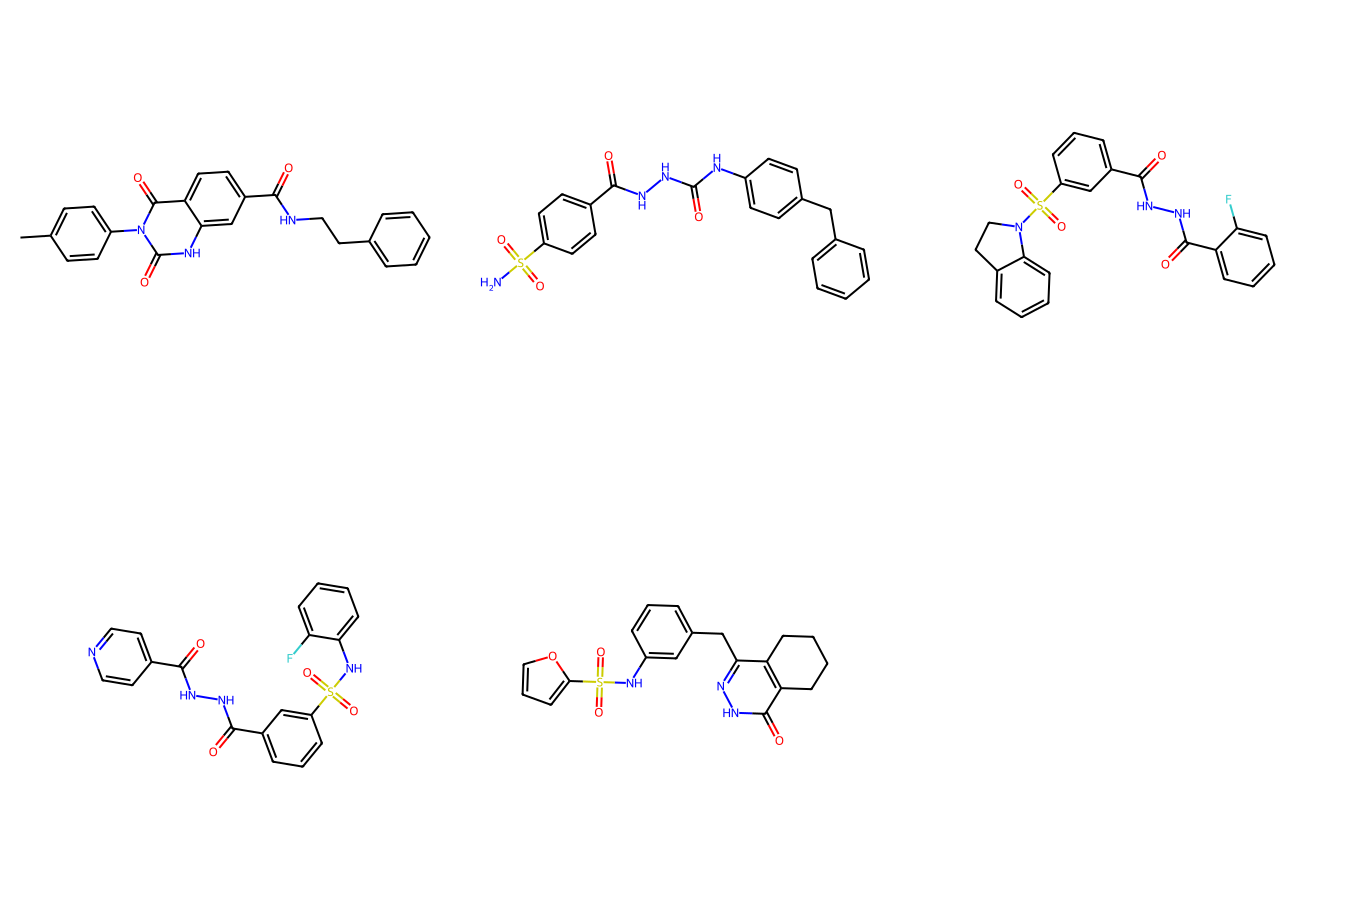

In [27]:
# Double check the lowest scoring compound manually (low scoring is better).

a = Chem.MolFromSmiles('Cc1ccc(-n2c(=O)[nH]c3cc(C(=O)NCCc4ccccc4)ccc3c2=O)cc1')
b = Chem.MolFromSmiles('NS(=O)(=O)c1ccc(C(=O)NNC(=O)Nc2ccc(Cc3ccccc3)cc2)cc1')
c = Chem.MolFromSmiles('O=C(NNC(=O)c1ccccc1F)c1cccc(S(=O)(=O)N2CCc3ccccc32)c1')
d = Chem.MolFromSmiles('O=C(NNC(=O)c1cccc(S(=O)(=O)Nc2ccccc2F)c1)c1ccncc1')
e = Chem.MolFromSmiles('O=c1[nH]nc(Cc2cccc(NS(=O)(=O)c3ccco3)c2)c2c1CCCC2')

Draw.MolsToGridImage((a,b,c,d,e), subImgSize=(450,450))


In [54]:
def run():
    prep_smiles(smiles_csv)
    prepare_and_merge_ligands(filtered_std_smiles, pH, output_dir=sdf_folder)
    os.remove(filtered_std_smiles)
    os.system(docking_cmd)
    os.remove(ligands)
    affinities_to_smiles(docking_output)

In [ ]:
run()

In [ ]:
from pathlib import Path

merged_sdf = Path(f"{DATAPATH}/reference_output_2/merged_top100_poses.sdf")
Path(f"{DATAPATH}/reference_output_2".glob("*.sdf"))
